<a href="https://colab.research.google.com/github/lucadonnoh/progetto-deblur/blob/main/Progetto_Deblur_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [95]:
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n)) 
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

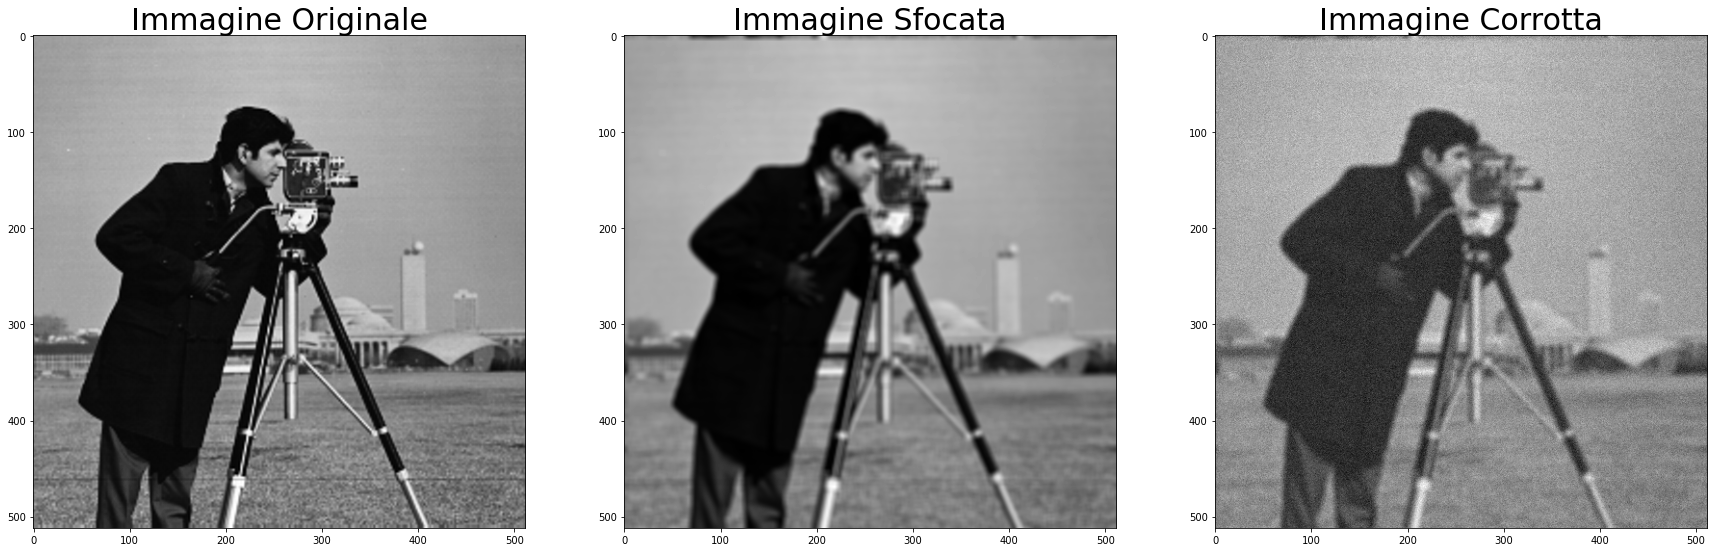

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters

# 1
X = data.camera()
m, n = X.shape
x = X.reshape(m*n) # array m*n


# 2
X_blur = A(X) # matrice
x_blur = X_blur.reshape(m*n) # array


# 3
# Generiamo il rumore eta
sigma = 0.1 # Varianza del rumore
eta = np.random.normal(size=X_blur.shape) # random gaussian distribution
eta /= np.linalg.norm(eta, 'fro') # norma di frobenius
eta *= sigma * np.linalg.norm(X_blur,'fro')

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta
b = B.reshape(m*n)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [97]:
def plot( iters, error, title): 
  err_iteration = np.linspace(1, iters, error.size)
  plt.plot(err_iteration, error)
  plt.title(title)
  plt.grid()
  plt.show()

def find_x(error):
  return np.where(error == np.amin(error))[0]

MAXITERATIONS=50
ABSOLUTE_STOP=1.e-5

alpha = 1.1
rho = 0.5
c1 = 0.25
k = 0

def lambottimale(x, b, max):
  lamb=0.00000001
  k=0
  x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
  rat = 1.1
  while np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2:
    lamb *= rat
    x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
    k+=1
    print(",", end='')
  print("it: ", k)
  return lamb/rat

In [98]:
# 4 - 5 
#Modificare l'algoritmo è stato interpretato come "sovrascrivere il precedente"

def f(x, b): #
  return 0.5*(np.linalg.norm(A(x)-b))**2

def grad_f(x, b):
  return AT(A(x)-b)

def next_step(x, b, f, grad):

  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f(x-alpha*grad, b) > f(x, b) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize(x0, x_true, b, maxit, abstop):
  x = x0
  grad = grad_f(x, b)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step(x, b, f, grad) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f(x, b)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
    k += 1
    print(".", end='')

  err = err[0:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)


..................................................

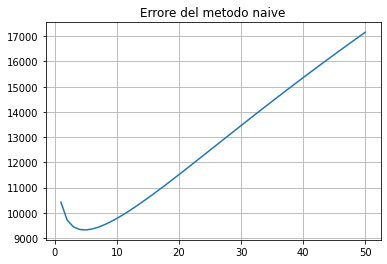

.....[9318.41956405]


In [99]:
x_naive, ite_naive, err_naive = minimize(B, X, B, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
plot(ite_naive, err_naive,"Errore del metodo naive")

X_trunc_index = find_x(err_naive)
X_trunc,_,_= minimize(B,X,B,X_trunc_index+1, ABSOLUTE_STOP)
print(err_naive[X_trunc_index])

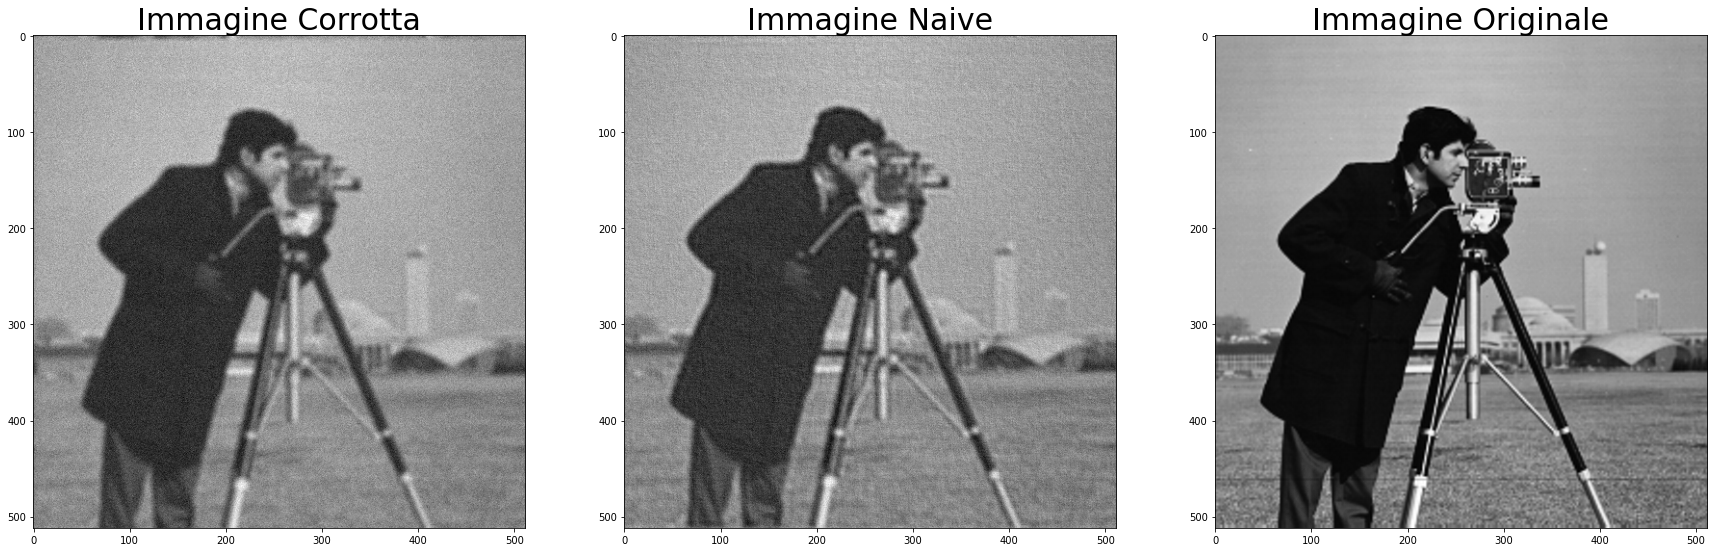

In [100]:
#Plottiamo il risultato
plt.figure(figsize=(30, 10))

fig1 = plt.subplot(1, 3, 1)
fig1.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig2 = plt.subplot(1, 3, 2)
fig2.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig3 = plt.subplot(1, 3, 3)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [101]:
def f_reg(x, b, lamb):
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2

def grad_f_reg(x, b, lamb):
  return AT(A(x)-b) + lamb*x

def next_step_reg(x, b, f, grad, lamb):

  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg(x-alpha*grad, b, lamb) > f_reg(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    #print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)


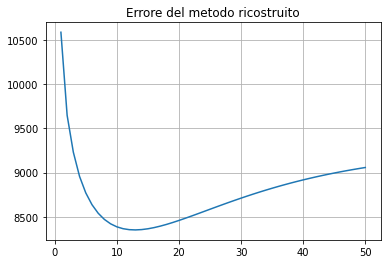

[8351.72804291]


In [102]:
#lamda calcolato in modo euristico
lamb_reg = 0.03846986256908595 #lambda in modo euristico

(x_reg, ite_reg, err_reg) = minimize_reg(B, X, B, lamb_reg, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
plot(ite_reg, err_reg,"Errore del metodo ricostruito")

X_reg_index_rec = find_x(err_reg)
print(err_reg[X_reg_index_rec])
X_lambda,_,_= minimize_reg(B, X, B, lamb_reg, X_reg_index_rec+1, ABSOLUTE_STOP)



 [10585.00897825  9646.57850861  9229.6727415   8956.31817594
  8770.29458241  8636.98359667  8540.24387391  8470.22146367
  8420.54766068  8386.76960225  8365.61569997  8354.58850891
  8351.72804291  8355.46464409  8364.52267258  8377.85444264
  8394.59304076  8414.01744021  8435.52594347  8458.61547056
  8482.86508604  8507.92268859  8533.49412     8559.33416417
  8585.23904917  8611.04016192  8636.59875293  8661.8014573
  8686.55649368  8710.7904304   8734.44542807  8757.47688451
  8779.85142046  8801.54515491  8822.54222705  8842.83352884
  8862.41561779  8881.28978391  8899.46124921  8916.93848087
  8933.73260227  8949.85688822  8965.32633275  8980.15727943
  8994.36710572  9007.97395382  9020.9965018   9033.45376942
  9045.36495402  9056.7492922 ]


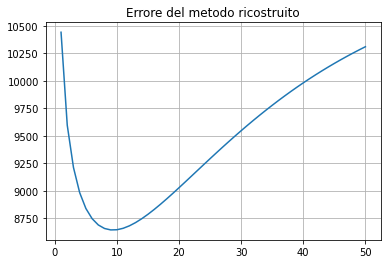

[8645.01670713]


In [103]:
#lamda tramite condizione discrepanza
lamb_disc = 0.025625815225418787 

x0 = np.zeros(X.shape) # immagine ricostruita al passo 0
(X_reg2, ite_reg2, err_reg2) = minimize_reg(B, X, B, lamb_disc, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg)
plot(ite_reg2, err_reg2,"Errore del metodo ricostruito")

X_reg_index2 = find_x(err_reg2)
print(err_reg2[X_reg_index2])
X_lambda_disc,_,_= minimize_reg(B, X, B, lamb_disc, X_reg_index2+1, ABSOLUTE_STOP)

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [105]:
def f_reg_1(x, b, lamb): #
  return 0.5*(np.linalg.norm(A(x)-b))**2 + lamb*np.linalg.norm(x, 1)

def grad_f_reg_1(x, b, lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def next_step_reg_1(x, b, f, grad, lamb):

  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_1(x-alpha*grad, b, lamb) > f_reg_1(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_1(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg_1(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_1(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_1(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

..................................................
 [10418.46715716  9712.45793585  9438.78303549  9332.23123036
  9313.00443898  9347.28504937  9417.75825612  9514.37291826
  9630.72834011  9762.46116487  9906.42713112 10060.27218068
 10222.1731511  10390.6839927  10564.63181147 10743.04981448
 10925.1347019  11110.21094904 11297.70391971 11487.12139979
 11678.04666388 11870.11963925 12063.02817256 12256.50286999
 12450.30856492 12644.24142188 12838.12549489 13031.80438491
 13225.14800062 13418.03907516 13610.37657078 13802.07284436
 13993.05147139 14183.2502996  14372.6097196  14561.08229574
 14748.62588883 14935.20602031 15120.7931756  15305.36345429
 15488.89686853 15671.37796919 15852.79259052 16033.1316175
 16212.38824658 16390.55496157 16567.63131458 16743.61621683
 16918.51093895 17092.31443453]


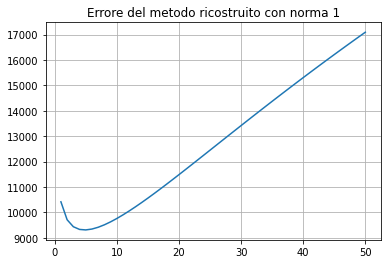

[9313.00443898]
.....

In [120]:
#Punto 8,  norma 1

lamb_1 = 0.025625815225418787 #lamda tramite condizione discrepanza

(x_rec_1, ite_rec_1, err_reg_1) = minimize_reg_1(B, X, B, lamb_1, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg_1)
plot(ite_rec_1, err_reg_1,"Errore del metodo ricostruito con norma 1")

X_reg_index_1 = find_x(err_reg_1)
print(err_reg_1[X_reg_index_1])
X_lambda_1,_,_= minimize_reg_1(B, X, B, lamb_1, X_reg_index_1+1, ABSOLUTE_STOP)

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [107]:
def f_reg_mista(x, b, lamb, mu): 
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2 + mu*np.linalg.norm(x,1)

def grad_f_reg_mista(x, b, lamb, mu):
  return AT(A(x)-b) + lamb*x +  mu*np.sign(x)

def next_step_reg_mista(x, b, f, grad, lamb, mu):

  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_mista(x-alpha*grad, b, lamb, mu) > f_reg_mista(x, b, lamb, mu) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_mista(x0, x_true, b, lamb, mu, maxit, abstop):
  x = x0
  grad = grad_f_reg_mista(x, b, lamb, mu)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_mista(x, b, f, grad, lamb, mu) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_mista(x, b, lamb, mu)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

..................................................
 [10416.06397816  9595.20109957  9224.1544278   9010.71785425
  8882.07579361  8804.96114016  8762.64987121  8745.3379961
  8746.75244743  8762.59063181  8789.73525336  8825.84301357
  8869.08363577  8918.00947547  8971.44669417  9028.43288889
  9088.17337184  9150.001273    9213.36075796  9277.78159615
  9342.86803153  9408.2876961   9473.75739093  9539.03816735
  9603.93015405  9668.25963039  9731.88802584  9794.69663284
  9856.58845344  9917.48279498  9977.31590948 10036.03556296
 10093.60226415 10149.98622525 10205.16287477 10259.1144221
 10311.83513673 10363.31848674 10413.56910397 10462.58871717
 10510.38934801 10556.97988828 10602.37480763 10646.58901083
 10689.64153513 10731.54766502 10772.32834995 10812.00612008
 10850.60198885 10888.13849371]


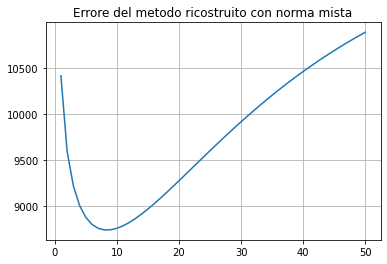

[8745.3379961]
........

In [108]:
#Punto 9,  norma mista

lamb = 0.02155582137126536
mu = 0.025625815225418787

(x_rec_mista, ite_rec_mista, err_reg_mista) = minimize_reg_mista(B, X, B, lamb, mu, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg_mista)
plot(ite_rec_mista, err_reg_mista,"Errore del metodo ricostruito con norma mista")

X_reg_mista = find_x(err_reg_mista)
print(err_reg_mista[X_reg_mista])
X_lambda_mista,_,_= minimize_reg_mista(B, X, B, lamb, mu, X_reg_mista+1, ABSOLUTE_STOP)

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


In [119]:
def er(x, x_true):
  return np.linalg.norm(x-x_true)/np.linalg.norm(x_true)

def print_errors():
  er_naive = er(X_trunc, X)
  er_reg = er(X_lambda, X)
  er_reg2 = er(X_lambda_disc, X)
  er_1 = er(X_lambda_1, X)
  #er_mista = er(X_lamda_mista, X)
  er_b = er(B, X)

  print("Errore percentuale immagine corrotta:", er_b*100, "%")
  print("Errore percentuale immagine naive:", er_naive*100, "%")
  print("Errore percentuale immagine regolarizzata:", er_reg*100 ,"%")
  print("Errore percentuale immagine regolarizzata2:", er_reg2*100, "%")
  print("Errore percentuale immagine regolarizzata con norma 1", er_1*100,"%")
  #print("Errore percentuale immagine regolarizzata con norma mista", er_mista , "%")
  print()

M,N = X.shape

def PSNR(A):
  return 20*np.log10(A.max()/((1/(M*N))*np.linalg.norm(eta)))

def print_PSNR():

  print("PSNR immagine corrotta:", PSNR(B))
  print("PSNR immagine naive:", PSNR(X_trunc))
  print("PSNR immagine immagine regolarizzata:", PSNR(X_lambda))
  print("PSNR immagine immagine regolarizzata2:", PSNR(X_lambda_disc))
  print("PSNR immagine regolarizzata con norma 1:", PSNR(X_lambda_1))
  #print("PSNR immagine regolarizzata con norma mista:", PSNR(X_lamda_mista))


print_errors()
print_PSNR()

Errore percentuale immagine corrotta: 20.801504195191477 %
Errore percentuale immagine naive: 13.625549588312 %
Errore percentuale immagine regolarizzata: 12.21203701063063 %
Errore percentuale immagine regolarizzata2: 12.640888621205734 %
Errore percentuale immagine regolarizzata con norma 1 13.617631501493301 %

PSNR immagine corrotta: 80.39597411869451
PSNR immagine naive: 81.00268385824138
PSNR immagine immagine regolarizzata: 80.36342749504897
PSNR immagine immagine regolarizzata2: 80.61028258273446
PSNR immagine regolarizzata con norma 1: 81.00191588556444


In [ ]:
#Plottiamo il risultato #da finireee
plt.figure(figsize=(30, 15))

fig0 = plt.subplot(2, 2, 2)
fig0.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig1 = plt.subplot(2, 2, 3)
fig1.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig2 = plt.subplot(2, 2, 4)
fig2.imshow(X_lambda_disc, cmap='gray')
plt.title('Immagine Regolarizzata', fontsize=30)

fig3 = plt.subplot(2, 2, 1)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

